<a href="https://www.kaggle.com/code/zostaw/understanding-neural-network?scriptVersionId=167600904" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
import math
from graphviz import Source
from IPython.display import display
import optuna
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Read it first

ML is so huge with milions of frameworks, utilizations, theories and optimization methods.  
I thought it's impossible for me to reason about it without understanding the basic building blocks, so... this is my interpretation of the things that I'm learning.  
It might be inacurrate, it might have some missrepresentations of why's, and how's, and the different concepts, so read with a reserve.  
I'm writing this notebook as a diary of my learning process, so that I can come back to the concepts that I struggled through and forgotten.  
I plan to contribute to it from time to time with new concept that I'm trying to understand, but maybe I won't - maybe I'll create completely separate one.

# Polynomials as function approximation

Usually to represent a relationship between inputs and outputs we define a function.  
But if the relationship does not follow an understood pattern, we cannot formulize it.
What do we do then? Well, if we have a lot of data that shows the relationship, we can try to approximate it.
In this notebook/chapter, I'm going to do it using polynomials.  
Let's start with inputs/outputs. For the purpose of simplicity, I'm going to choose a known function, but the same can be applied to any relationship.


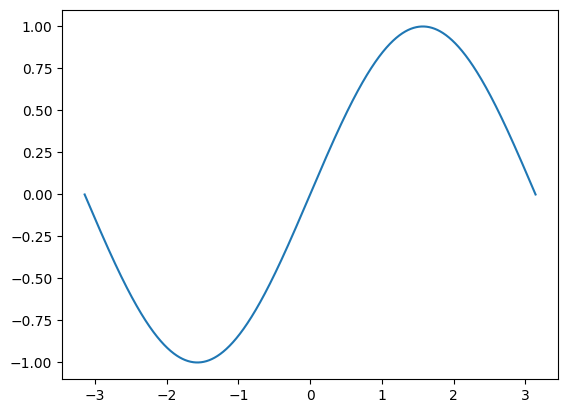

In [2]:
data_points = 10000
# inputs
x = torch.linspace(-torch.pi, torch.pi, 10000, dtype=torch.float)
# expected outputs - here is sin, but in real scenatio we dont' know what the function is, we just have **y**
y = torch.sin(x)
# display the expected relationship
plt.plot(x.cpu().numpy(), y.cpu().numpy())
plt.show()

A polynomial is defined with indeterminates (variables) and coefficients (weights).  
Ideally we want $\hat{y}(x)$ (in code below denoted as *y_pred*) to represent $y(x)$.  
In this case $y(x)=\sin(x)$, but it could be any function, in general we don't know what the function is, we only know the datapoints that represent it.  
But if we don't know the formula, we need to *find* the weights of the function.  
At the beginning we initialize them with random values.
Mentioned function can be represented in following form:

\begin{equation}
\tag{1}
\label{eq:y_pred}
\hat{y} = w_3 \cdot x^3 + w_2 \cdot x^2 + w_1 \cdot x + w_0
\end{equation}

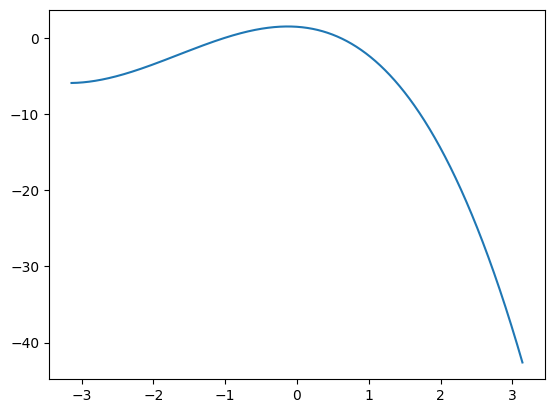

In [3]:
# seed generator for the sake of reproducibility
#     -> coefficients will be random, but determined for the sake of this notebook
torch.manual_seed(69)

# initiate coefficients
w3 = torch.randn((), dtype=torch.float)
w2 = torch.randn((), dtype=torch.float)
w1 = torch.randn((), dtype=torch.float)
w0 = torch.randn((), dtype=torch.float)
# define the polynomial
y_pred = w3 * x**3 + w2 * x**2 + w1 * x + w0

plt.plot(x, y_pred)
plt.show()

That defined function is rather poor approximation of the function.  
So, we need to find a way to update weights, so that they do it better.  
In order to do it we can represent the difference between the expected outcome and predicted one.  
This is called loss function/cost function.  
In Machine Learning and in information technologies, it is often calculated with Measure Squared Error.  
It is defined as such:
\begin{equation}
\tag{2}
\label{eq:loss}
Loss = MSE = \frac{1}{n} \sum_{i=1}^{n} (\hat{y}_{i} - y_{i})^2 = \frac{1}{n} \sum_{i=1}^{n} (\hat{y}_{i}^2 - 2 \hat{y}_{i} y_{i} + y_{i}^2)
\end{equation}
$n$ in the equation is the data sample size - number of samples that we calculate the error against.


In [4]:
loss = torch.pow(y_pred - y, 2).sum()/data_points

We can visualize the relationship between $\hat{y}(x)$, $y(x)$ and *loss*

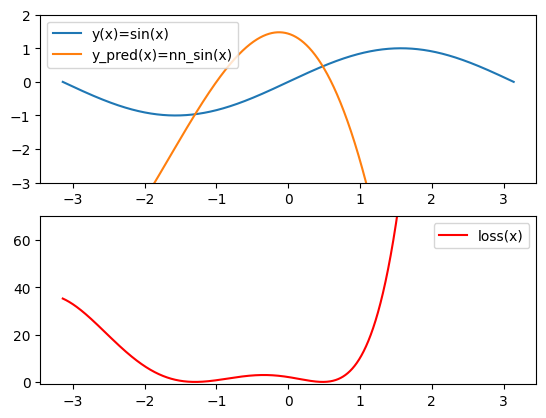

In [5]:
_, ax = plt.subplots(2, 1)
ax[0].plot(x, y, label="y(x)=sin(x)")
ax[0].plot(x, y_pred, label="y_pred(x)=nn_sin(x)")
ax[0].legend()
ax[0].set_ylim((-3, 2))
ax[1].plot(x, torch.pow(y_pred - y, 2), label="loss(x)", color='red')
ax[1].legend()
ax[1].set_ylim((-1, 70))
plt.show()

The representation above is strictly dependent on the random values that we initialized weights with.  
But some things can be said independent on what are the actual values.  
Notice, the prediction function is very close to original function in some places. For those values, loss is very small, close to zero.  
In other places maybe it's close, but not close enough.
For some values it's probably sky-high, not even visible on the diagram. 


So, we want to adjust the weights/coefficients of the prediction function to minimize this loss.
Now, we must realize that the loss represents loss in regards to the datapoints we presented.
If we pick specific numbers, we might think the function is almost perfect. This is why it's important to have a big, high-quality *training* input data, because we want the function to represent the entire function, not just parts of it. Ideally you want it to predict values that are not in the *training* set - this is the whole point of defining the function - to aproximate it such, that it shows the relationship between the input data and output data, so that when output data is not available - we can derive it using the neural network.  


How to achieve that? We use algorithm that combines helps to update the weights based on the Loss function values.  
A common optimization algorithm is gradient descent defined as such:  

\begin{equation}
\tag{3}
\label{eq:grad_descent}
w_{new} = w_{old} - \gamma \cdot \frac{\partial Loss}{\partial w_{old}}
\end{equation}

where $\gamma$ is learning rate - it defines how big will be change of weight  
      $\frac{\partial Loss}{\partial w_{old}}$ is partial derivative of the Loss function in respect to the weight  
      
To calculate partial derivatives is a monotonous task, especially if NN has a lot of weights and the relationships are complicated. We can use different approaches to the problem:
- manual differentiation
- symbolic differentiation
- numerical differentiation
- autodiff
In machine learning autodiff/autograd is a commonly used technique that uses computational optimization to calculate derivatives quickly (problem of manual/symbolic techniques) and accurately (numerical differential problem).
It is based on a concept of chain rule, which allows to calculate derivative of a composite function using component derivatives. Chain rule is defined on a function as such:  

\begin{equation}
\tag{4}
f(x) = f(g(x)) \Rightarrow \frac{\partial f}{\partial x} = \frac{\partial f}{\partial g} \cdot \frac{\partial g}{\partial x}
\end{equation}

The meaning of it is such that we can calculate partial derivative of Loss function in respect to the predicted output and use it to calculate derivatives in respect to the weights.  
We can look at relationship between *loss* and *y_pred* ($\hat{y}$) in following way:  

\begin{equation}
\tag{5}
Loss = \hat{y}(x)  
\end{equation}

and between *y_pred* and weights as following:  

\begin{equation}
\tag{6}
\hat{y} = f(g(h(i(x)))) = f(g(h(i(w_{0})))) = f(g(h(w_{1}))) = f(g(w_{2})) = f(w_{3}) = w_{4}
\end{equation}

From that we have following relationship:  

\begin{equation}
\label{eq:loss_grad_for_weights}
\tag{7}
\frac{\partial Loss}{\partial w_{i}} = \frac{\partial Loss}{\partial \hat{y}} \cdot \frac{\partial \hat{y}}{\partial w_{i}} 
\end{equation}

The first part can be calculated from $(2)$, here for single sample:
\begin{equation}
\tag{8}
\label{eq:loss_grad}
\frac{\partial Loss}{\partial \hat{y}_i} = 2(\hat{y}_{i} - y_{i})
\end{equation}

The second part can derived from (1) and is following:

\begin{equation}
\tag{9}
\label{eq:y_grads_for_weights}
\frac{\partial \hat{y}}{\partial w_{0}} = 1 \\
\frac{\partial \hat{y}}{\partial w_{1}} = x \\
\frac{\partial \hat{y}}{\partial w_{2}} = x^2 \\
\frac{\partial \hat{y}}{\partial w_{3}} = x^3
\end{equation}

The partial derivatives can be calculated then from (\ref{eq:loss_grad_for_weights}), (\ref{eq:loss_grad}) and (\ref{eq:y_grads_for_weights}) as follows:

\begin{equation}
\tag{10}
\label{eq:weights_grads}
\frac{\partial Loss}{\partial w_{0}} = \frac{\partial Loss}{\partial \hat{y}} \cdot 1 \\
\frac{\partial Loss}{\partial w_{1}} = \frac{\partial Loss}{\partial \hat{y}} \cdot x \\
\frac{\partial Loss}{\partial w_{2}} = \frac{\partial Loss}{\partial \hat{y}} \cdot x^2 \\
\frac{\partial Loss}{\partial w_{3}} = \frac{\partial Loss}{\partial \hat{y}} \cdot x^3
\end{equation}

And that's what we're calling back propagation.  
We can use then (\ref{eq:weights_grads}) to calculate gradient descent (\ref{eq:grad_descent}) and optimize weights as follows:

\begin{equation}
\tag{11}
\label{eq:weights_grad_descent}
w_{i\ new} = w_{i\ old} - \gamma \cdot \frac{\partial Loss}{\partial w_{i\ old}}
\end{equation}

So, after evaluating the equations it will look following for particular weights:

\begin{equation}
\tag{12}
\label{eq:weights_optimization_solution}
w_{0\ new} = w_{0\ old} - \gamma \cdot \frac{\partial Loss}{\partial \hat{y}} \cdot 1 \\
w_{1\ new} = w_{1\ old} - \gamma \cdot \frac{\partial Loss}{\partial \hat{y}} \cdot x \\
w_{2\ new} = w_{2\ old} - \gamma \cdot \frac{\partial Loss}{\partial \hat{y}} \cdot x^2 \\
w_{3\ new} = w_{3\ old} - \gamma \cdot \frac{\partial Loss}{\partial \hat{y}} \cdot x^3 \\
\end{equation}

The above equation works for single input. For entire dataset it would look more like:

\begin{equation}
\tag{13}
\label{eq:weights_optimization_solution_tensor}
w_{0\ new} = w_{0\ old} - \gamma \cdot \sum_{i=1}^{n} \frac{1}{n} \cdot \frac{\partial Loss}{\partial \hat{y}_i} \cdot 1 \\
w_{1\ new} = w_{1\ old} - \gamma \cdot \sum_{i=1}^{n} \frac{1}{n} \cdot \frac{\partial Loss}{\partial \hat{y}_i} \cdot x_i \\
w_{2\ new} = w_{2\ old} - \gamma \cdot \sum_{i=1}^{n} \frac{1}{n} \cdot \frac{\partial Loss}{\partial \hat{y}_i} \cdot x_i^2 \\
w_{3\ new} = w_{3\ old} - \gamma \cdot \sum_{i=1}^{n} \frac{1}{n} \cdot \frac{\partial Loss}{\partial \hat{y}_i} \cdot x_i^3 \\
\end{equation}


In [6]:
# we define gamma from equation (3)
learning_rate = 1e-5

# Loss gradient with respect to y_pred - equation (8)
y_pred_grad = 2*(y_pred - y)

# partial Loss gradients with respect to each coefficient - equation (10)
w0_grad = y_pred_grad.sum()/data_points
w1_grad = (y_pred_grad * x).sum()/data_points
w2_grad = (y_pred_grad * x**2).sum()/data_points
w3_grad = (y_pred_grad * x**3).sum()/data_points

# optimization - gradient descent - equation (12)
w0 -= learning_rate * w0_grad
w1 -= learning_rate * w1_grad
w2 -= learning_rate * w2_grad
w3 -= learning_rate * w3_grad


Now, we can visualize the difference.

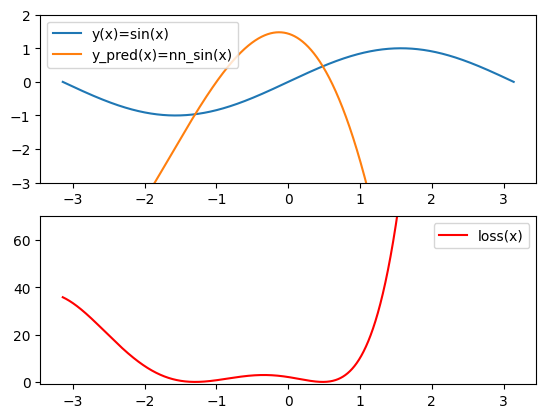

In [7]:
# y_pred is in form of calculation, so I re-evaluate it here, normally y_pred is evaluated during forward propagation, but here I want to visualize the change
y_pred = w3 * x**3 + w2 * x**2 + w1 * x + w0
# calculate loss
loss = torch.pow(y_pred - y, 2).sum()/data_points

_, ax = plt.subplots(2, 1)
ax[0].plot(x, y, label="y(x)=sin(x)")
ax[0].plot(x, y_pred, label="y_pred(x)=nn_sin(x)")
ax[0].legend()
ax[0].set_ylim((-3, 2))
ax[1].plot(x, torch.pow(y_pred - y, 2), label="loss(x)", color='red')
ax[1].legend()
ax[1].set_ylim((-1, 70))
plt.show()

As can be seen above, both *y_pred(x)* and *loss(x)* changed.  
If we continue to iterate through the steps, y_pred(x) should converge to approximate y(x) and loss(x) should converge to 0.
We can define training loop to achieve that.
The steps would be this:
1. run inputs through function - forward propagation
2. calculate loss function
3. calculate gradients - backward propagation
4. optimize weights - gradient descent
5. iterate through 1-4 to achieve as low loss as possible


Epoch: 300, loss: 1.45915546875, learning_rate: 0.001, number of data points: 10000
y_pred = [0.0540299229323864]*x^3 + [-0.2439226657152176]*x^2 +[-0.17854160070419312]*x +[1.4126651287078857]


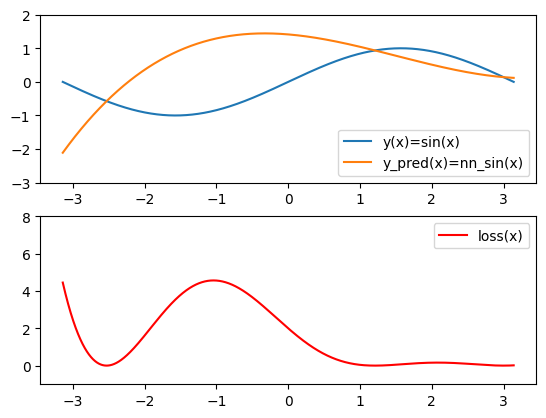

Epoch: 600, loss: 0.8382158203125, learning_rate: 0.001, number of data points: 10000
y_pred = [0.014760098420083523]*x^3 + [-0.18821455538272858]*x^2 +[0.09731512516736984]*x +[1.090083360671997]


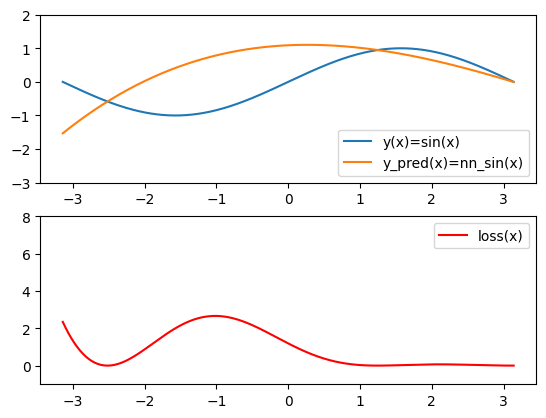

Epoch: 900, loss: 0.48344794921875, learning_rate: 0.001, number of data points: 10000
y_pred = [-0.014048018492758274]*x^3 + [-0.14523564279079437]*x^2 +[0.29968202114105225]*x +[0.8411620855331421]


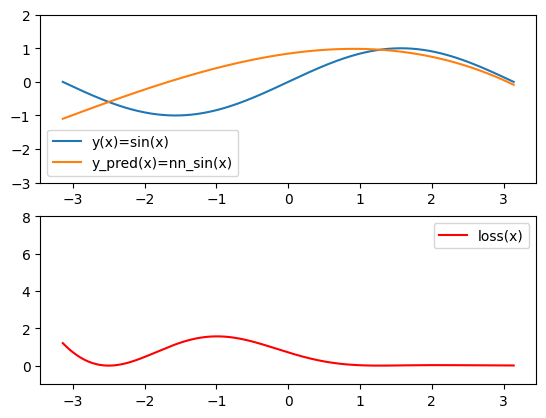

Epoch: 1200, loss: 0.2802580322265625, learning_rate: 0.001, number of data points: 10000
y_pred = [-0.03518153727054596]*x^3 + [-0.11207102984189987]*x^2 +[0.4481375813484192]*x +[0.6490824222564697]


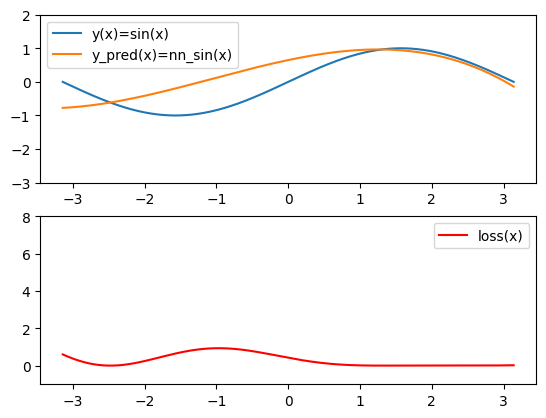

Epoch: 1500, loss: 0.1636041748046875, learning_rate: 0.001, number of data points: 10000
y_pred = [-0.050684962421655655]*x^3 + [-0.08647944778203964]*x^2 +[0.5570436716079712]*x +[0.5008634924888611]


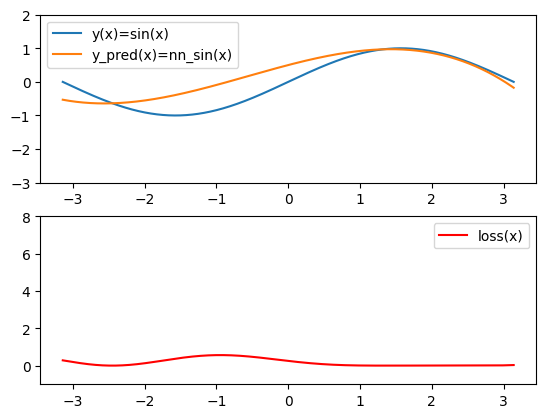

Epoch: 1800, loss: 0.09647648315429687, learning_rate: 0.001, number of data points: 10000
y_pred = [-0.06205810606479645]*x^3 + [-0.06673180311918259]*x^2 +[0.6369360089302063]*x +[0.38649097084999084]


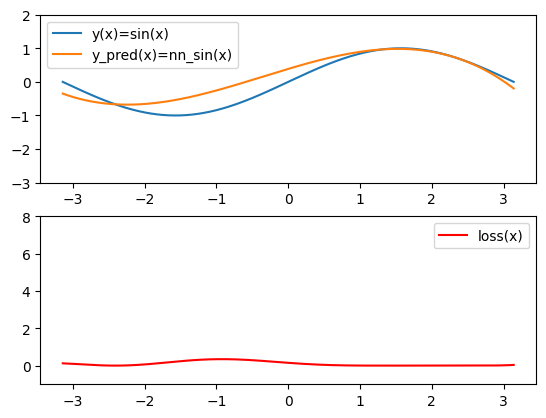

Epoch: 2100, loss: 0.05776088256835937, learning_rate: 0.001, number of data points: 10000
y_pred = [-0.07040152698755264]*x^3 + [-0.051493559032678604]*x^2 +[0.6955456137657166]*x +[0.2982354760169983]


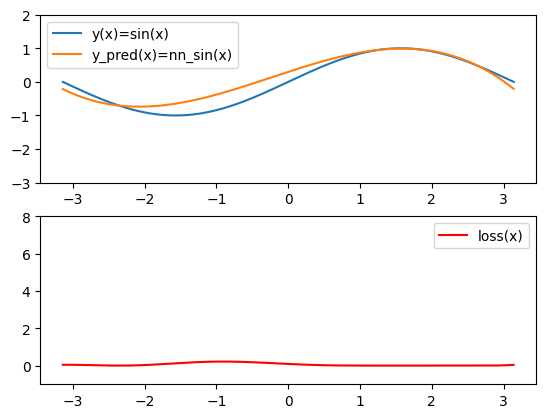

Epoch: 2400, loss: 0.03538365478515625, learning_rate: 0.001, number of data points: 10000
y_pred = [-0.0765221118927002]*x^3 + [-0.03973497077822685]*x^2 +[0.7385405898094177]*x +[0.23013325035572052]


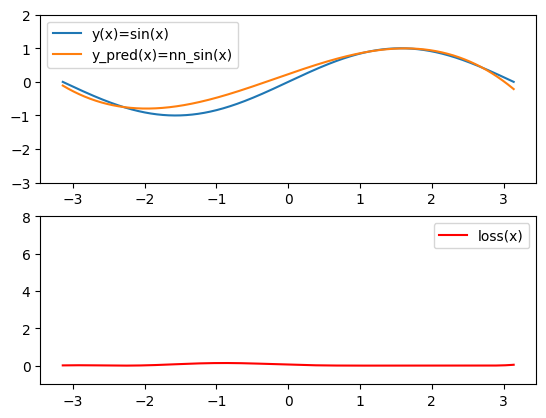

Epoch: 2700, loss: 0.022422853088378908, learning_rate: 0.001, number of data points: 10000
y_pred = [-0.08101213723421097]*x^3 + [-0.030661460012197495]*x^2 +[0.7700814604759216]*x +[0.17758214473724365]


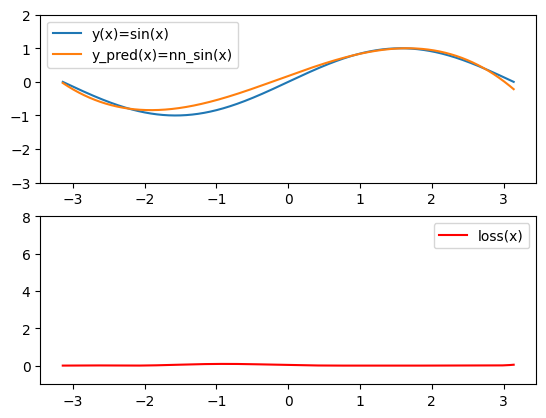

Epoch: 3000, loss: 0.014901089477539063, learning_rate: 0.001, number of data points: 10000
y_pred = [-0.0843060091137886]*x^3 + [-0.023659905418753624]*x^2 +[0.7932197451591492]*x +[0.13703122735023499]


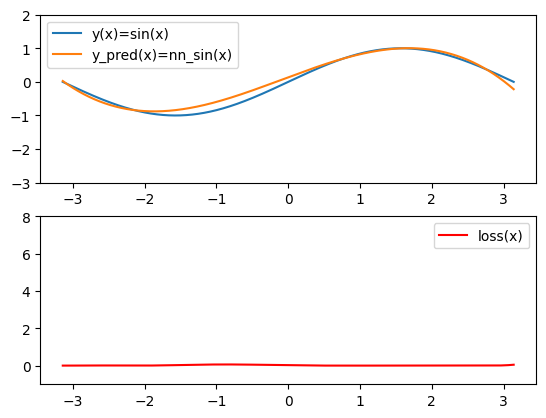

In [8]:
# metaparameters and things
epochs = 3000
learning_rate = 1e-3
data_points = len(y_pred)

# forward propagation which is exactly the same as y_pred
def forward(x, y, w0, w1, w2, w3):
    return w3 * x**3 + w2 * x**2 + w1 * x + w0

def backward_propagation(x, y, y_pred, w0, w1, w2, w3, data_points, learning_rate):
    # Loss gradient with respect to y_pred
    y_pred_grad = 2.0*(y_pred - y)

    # partial Loss gradients with respect to each coefficient - equation (10)
    w0_grad = y_pred_grad.sum()/data_points
    w1_grad = (y_pred_grad * x).sum()/data_points
    w2_grad = (y_pred_grad * x**2).sum()/data_points
    w3_grad = (y_pred_grad * x**3).sum()/data_points

    # optimization - gradient descent
    w0 -= learning_rate * w0_grad
    w1 -= learning_rate * w1_grad
    w2 -= learning_rate * w2_grad
    w3 -= learning_rate * w3_grad

    return w0, w1, w2, w3

def visualize_training(x, y, y_pred):
    _, ax = plt.subplots(2, 1)
    ax[0].plot(x, y, label="y(x)=sin(x)")
    ax[0].plot(x, y_pred, label="y_pred(x)=nn_sin(x)")
    ax[0].legend()
    ax[0].set_ylim((-3, 2))
    ax[1].plot(x, torch.pow(y_pred - y, 2), label="loss(x)", color='red')
    ax[1].legend()
    ax[1].set_ylim((-1, 8))
    plt.show()

for epoch in range(epochs):
    # forward propagation
    y_pred = forward(x, y, w0, w1, w2, w3)
    # calculate loss function - for entire input
    loss = (y_pred - y).pow(2).sum().item()/data_points
    # backward propagation and optimization
    w0, w1, w2, w3 = backward_propagation(x, y, y_pred, w0, w1, w2, w3, data_points, learning_rate)

    # display state every 10% of epochs
    if not (epoch+1)%(epochs/10):
        y_pred = forward(x, y, w0, w1, w2, w3)
        print(f"Epoch: {epoch + 1}, loss: {loss}, learning_rate: {learning_rate}, number of data points: {data_points}")
        print(f"y_pred = [{w3}]*x^3 + [{w2}]*x^2 +[{w1}]*x +[{w0}]")
        visualize_training(x, y, y_pred)



## Polynomials

What is Polynomial really? We have a function **(1)** which defines parameters that influcence $x$.
Let's try to visualize it.

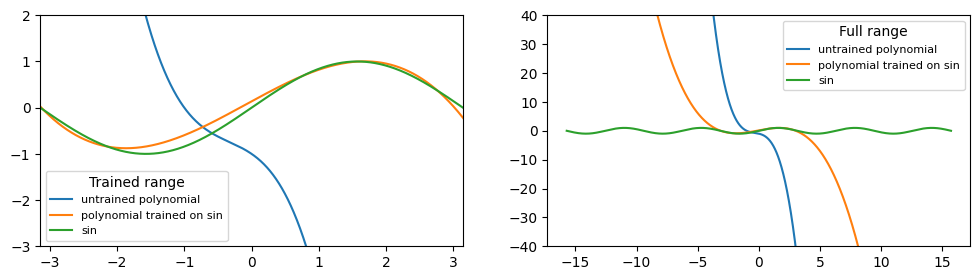

In [9]:
# inputs
x = torch.linspace(-5*torch.pi, 5*torch.pi, 10000, dtype=torch.float)
y_test = forward(x, y, w0, w1, w2, w3)
y_test_dummy = forward(x, y, -1, -1, -1, -1)
# expected outputs - here is sin, but in real scenatio we dont' know what the function is, we just have **y**
# display the expected relationship
fig, ax = plt.subplots(1, 2, figsize=(12, 3))
ax[0].plot(x.cpu().numpy(), y_test_dummy.cpu().numpy(), label="untrained polynomial")
ax[0].plot(x.cpu().numpy(), y_test.cpu().numpy(), label="polynomial trained on sin")
ax[0].plot(x.cpu().numpy(), np.sin(x), label="sin")
ax[0].set_xlim((-np.pi, np.pi))
ax[0].set_ylim((-3, 2))
ax[0].legend(title="Trained range", fontsize=8)
ax[1].plot(x.cpu().numpy(), y_test_dummy.cpu().numpy(), label="untrained polynomial")
ax[1].plot(x.cpu().numpy(), y_test.cpu().numpy(), label="polynomial trained on sin")
ax[1].plot(x.cpu().numpy(), np.sin(x), label="sin")
ax[1].set_ylim((-40, 40))
ax[1].legend(title="Full range", fontsize=8)

plt.show()


As we can see, *trained sin* only approximates *sin* function in the area that we trained it in. It's not perfect, but it's very close.   
During training it is literally bent to fit the function that we expect it to approximate.  
So, the part of the function that relates to range of inputs we trained on is exactly fitting sinusoid.  
The shape is happening by adjusting the weights of different coefficients.

I used polynomial in form of $y = w_3 x^3 + w_2 x^2 + w_1 x + w_0$, but what's the difference between this and others?!

Why is the shape of the polynomial the way it is?  
And what is the relationship between the coefficients, really?!  


In [10]:
# Define the polynomial function - this is abstracted form of previous example with weights defined manually
def polynomial(x, coefficients):
    # Initialize polynomial value to 0
    poly_val = torch.tensor(0.0)

    # Calculate polynomial value using Horner's method for efficiency
    for coefficient in coefficients.flip(0):  # Iterate in reverse order
        poly_val = poly_val * x + coefficient

    return poly_val

**ChatGPT**:

In the mentioned example, I'm using Horner's method to evaluate the polynomial, which is a more efficient way to calculate polynomial values than explicitly using powers of "x". Horner's method takes advantage of the fact that a polynomial can be rewritten in a nested format that minimizes the number of multiplications.

To illustrate, a polynomial of the form:

\begin{equation}
f(x) = a_n x^n + a_{n-1} x^{n-1} + ... + a_2 x^2 + a_1 x + a_0
\end{equation}

can be rewritten as:


\begin{equation}
f(x) = (\cdots((a_n x + a_{n-1}) x + a_{n-2}) x + \cdots + a_1) x + a_0
\end{equation}

By doing so, we avoid the calculation of \( x^n, x^{n-1}, ... \) separately and successively build the polynomial result by starting from the highest coefficient, multiplying by "x", and adding the next coefficient.

Using power directly with "x" (i.e., `x**n`, `x**(n-1)`, etc.) is typically less efficient and can result in more numerical instability because it performs a separate multiplication for each power of "x", which increases the complexity from O(n) to O(n^2) for an nth-degree polynomial.

In Horner's rule, the use of powers is implicit, where you multiply by "x" in each iteration. This leverages the distributive property and reduces the polynomial to a series of multiplications and additions, without explicitly invoking power calculations, making it computationally more efficient.

To reiterate, the reason not to use explicit powers on "x" is to improve performance and numerical stability when evaluating polynomials.

In [11]:
# so this is just a way to calculate polynomial in simplier form
x_size = 10000
x = torch.linspace(-10, 10, x_size)

# Generate N polynomials and save their charecteristics
functions_len = 6
f1_y = []
#for degree_of_polynomial in range(1, functions_len+1):
#    with torch.no_grad():
        # initialize coeffs with ones: polynomial in form of y = x**N + x**N-1 + ... + x + 1
#        coefficients = torch.randn(degree_of_polynomial, dtype=torch.float32)
#        print(f"Polynomial order: {degree_of_polynomial}, coefficients shape: {coefficients.data.shape}, x size: {x.shape}")
#        f1_y.append(polynomial(x, coefficients))
coefficients = torch.tensor([1.], dtype=torch.float32)
f1_y.append(polynomial(x, coefficients))
coefficients = torch.tensor([1., 3.], dtype=torch.float32)
f1_y.append(polynomial(x, coefficients))
coefficients = torch.tensor([1., 1., 1.], dtype=torch.float32)
f1_y.append(polynomial(x, coefficients))
coefficients = torch.tensor([1., 4., 1., -4.], dtype=torch.float32)
f1_y.append(polynomial(x, coefficients))
coefficients = torch.tensor([1., 6., 1., -4., 1.], dtype=torch.float32)
f1_y.append(polynomial(x, coefficients))
coefficients = torch.tensor([2., 5., 1., -6., -1., 1.], dtype=torch.float32)
f1_y.append(polynomial(x, coefficients))

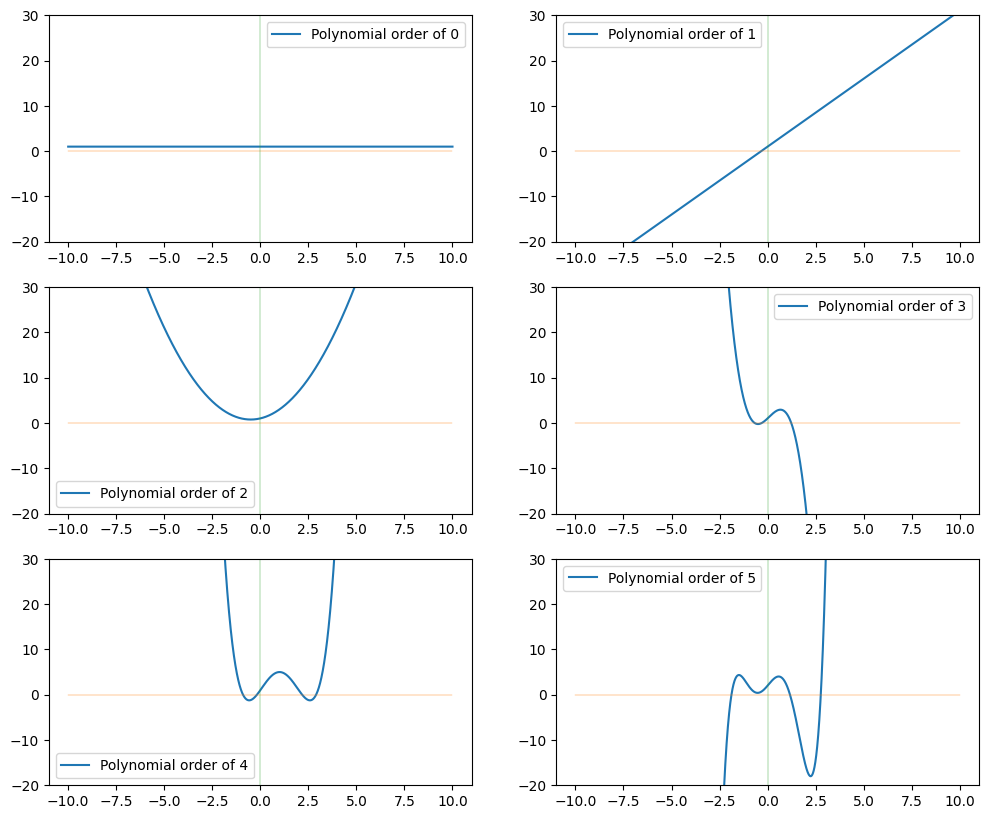

In [12]:

fig, ax = plt.subplots(int(functions_len/2), 2, figsize=(12, 10))
for f_id, f_y in enumerate(f1_y):
    row = int(math.floor(f_id/2))
    col = f_id%2
    ax[row][col].plot(x.cpu().numpy(), f_y.cpu().numpy(), label=f"Polynomial order of {f_id}")
    ax[row][col].plot([-10,10], [0,0], linewidth=.3) # y=0
    ax[row][col].plot([0,0], [-1e50, 1e50], linewidth=.3) # x=0
    # legends and limits
    ax[row][col].legend()
    ax[row][col].set_ylim((-20, 30))
plt.show()

One can imagine that by providing good amount of training points - polynomial can be **bent** to approximate any function.  
There are limits to this, though.  
For example it is impossible to fit polynomial of order 1 or 2 to represent sinusoid by any means.  
But as did in the first section it was quite possible to do with order 3 polynomial: $y = w_3 x^3 + w_2 x^2 + w_1 x + w_0$ for $x \in (-\pi ; \pi)$

In [13]:
# This is implementation from torch tutorial (you can check https://pytorch.org/tutorials/beginner/examples_nn/polynomial_nn.html for explanation of the function)

def polynomial_training(x, y, polynomial_order, learning_rate=1e-2, epochs=4_000, verbose=False):
    device = ("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
    x = x.to(device)
    y = y.to(device)
    # define model
    p = torch.linspace(1, polynomial_order, polynomial_order).int()
    xx = x.unsqueeze(-1).pow(p.to(device))
    model = torch.nn.Sequential(
        torch.nn.Linear(polynomial_order, 1),
        torch.nn.Flatten(0, 1)
    ).to(device)

    # train
    loss_fn = torch.nn.MSELoss(reduction='sum')
    optim = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for t in range(epochs):
        y_pred = model(xx)
        loss = loss_fn(y_pred, y)
        if (t % (epochs/10) == 99) and verbose:
            print(t, loss.item())

        # Zero the gradients before running the backward pass.
        optim.zero_grad()
        loss.backward()
        optim.step()

    return model(xx).to("cpu")

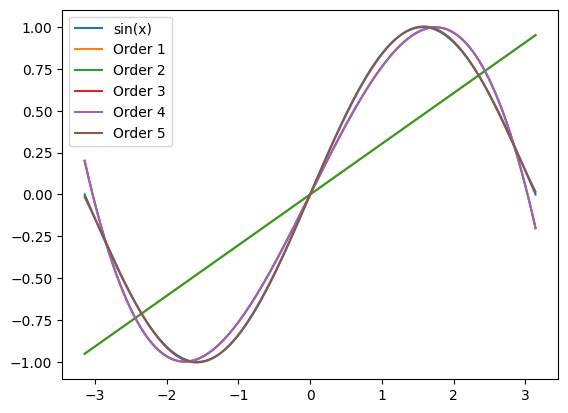

In [14]:
# Verify on sin(x) for reference
x = torch.linspace(-math.pi, math.pi, 1000)
y = torch.sin(x)
results = []
for polynomial_order in range(1, 6):
    results.append(polynomial_training(x, y, polynomial_order, learning_rate=1e-1, epochs=2_000))

# Plot results
fig, ax = plt.subplots()
ax.plot(x, y, label="sin(x)")
for pre_order, y_pred in enumerate(results):
    ax.plot(x, y_pred.detach().numpy(), label=f"Order {pre_order+1}")
    ax.set_title("")
plt.legend()
plt.show()

But the kinds of functions that can be approximated must always be smooth and there's limit to how much they can change. The limitation comes from the fact that polynomials have no more roots than the order of the polynomial.  
For example the above equation has 3 roots, which allowed to approximate $sin(x)$ in range $(-\pi; \pi)$.  
It was possible, because in that range $sin(x)$ has exactly 3 roots $\{ -\pi, 0, \pi \}$ - it would be impossible to do more than that.  
So, the lesson from that is that using polynomials is limitted to the shape of the function we are trying to approximate. Higher order of polynomial increases the capabilities, but for functions that have rough edges/sections it will not be precise. For example to aproximate step function, one would need to use high-order polynomial. Let's actually try to do it.  

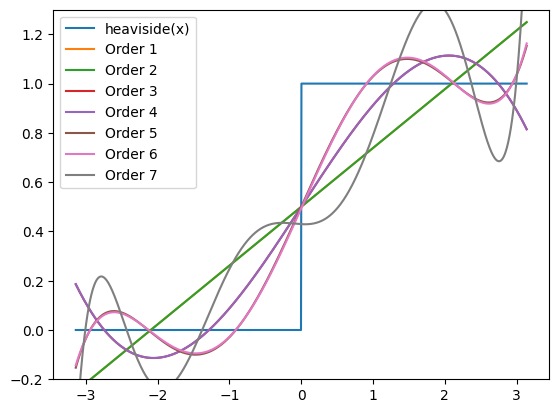

In [15]:
# See step function
x = torch.linspace(-math.pi, math.pi, 1000)
y = torch.heaviside(x, torch.tensor(0.))
results = []
for polynomial_order in range(1, 8):
    results.append(polynomial_training(x, y, polynomial_order, learning_rate=1e-1, epochs=2_000))

# Plot results
fig, ax = plt.subplots()
ax.plot(x, y, label="heaviside(x)")
for pre_order, y_pred in enumerate(results):
    ax.plot(x, y_pred.detach().numpy(), label=f"Order {pre_order+1}")
ax.set_title("")
ax.set_ylim((-0.2, 1.3))
plt.legend()
plt.show()

So, here we can see that it's really not working for a function with step characteristic. We can define a really high order polynomial and it will still not be a good function for that purpose.

## Alternatives

All above attempts to approximate the function were done using backpropagation method. But there other ways of approximating functions using polynomials. Some classic examples are:
- Taylor series and Newton-Raphson method
- Weierstrass transform
- Fourier series
- Radial basis function

# Neural Networks

Polynomials and other mathematical constructs are interesting ways of function approximation. In machine learning more common is building layers based on sum of multiple weighted linear functions and a step activation function.  

## Basic NN

The simpliest form of it is a perceptron. It consists of several inputs and bias, summed together and applied step function.  

In [16]:
device = ("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

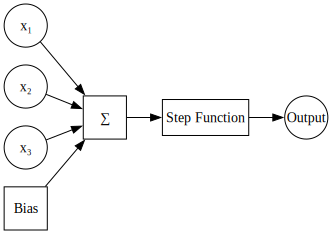

In [17]:
dot_graph = '''
digraph G {
    rankdir=LR;
    node [shape=circle, fixedsize=true, width=0.6];
    x1 [label="x₁"];
    x2 [label="x₂"];
    x3 [label="x₃"];
    bias [label="Bias", shape=square];
    sum [label="∑", shape=square];
    step [label="Step Function", shape=rectangle, width=1.2];
    y [label="Output"];

    x1 -> sum;
    x2 -> sum;
    x3 -> sum;
    bias -> sum;
    sum -> step;
    step -> y;
}
'''
source = Source(dot_graph)
display(source)

In below example we have a perceptron with single X, multiple weights in hidden layer and and output layer with single output.  
I'm going to use it to compare the neural net response to different types of input data shapes.  

In [18]:
class Perceptron(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size):
        super(Perceptron, self).__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(input_size, hidden_layer_size),
            nn.ReLU(),
            nn.Linear(hidden_layer_size, output_size),
        )

    def forward(self, x):
        logits = self.linear_stack(x)
        return logits

    def visualize_weights(self, verbose=True):
        # Get the weights from the model
        weights = []
        for param in self.parameters():
            if verbose:
                print(param)
            weights.append(param.flatten().detach().numpy())

        # Plot histogram of weights
        plt.figure(figsize=(6, 4))
        # plt.hist(weights, bins=5, color='blue', alpha=0.7)
        for weight in weights:
            plt.plot(range(len(weight)), weight)
        plt.title('Distribution of Model Weights')
        plt.xlabel('Neuron Id')
        plt.ylabel('Neuron weight')
        plt.grid(True)
        plt.show()

def nn_train(X, Y, model, loss_fn, optimizer, batch_size, epochs=10, device="cpu", verbose=True):
    dataset = CustomDataset(X, Y)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    torch.manual_seed(69)
    model.train(True)
    for i in range(epochs):
        acc_loss = 0
        num_batches = len(dataloader)
        for batch, (x, y) in enumerate(dataloader):
            optimizer.zero_grad()
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            loss.backward()
            optimizer.step()
            acc_loss += loss

        if verbose:
            print(f"average epoch loss: {acc_loss/num_batches}")

    model.eval()
    output = model(X.to(device)).to("cpu")
    return output.detach().numpy(), loss

class CustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        datapoint = self.x[idx]
        output = self.y[idx]
        return datapoint, output


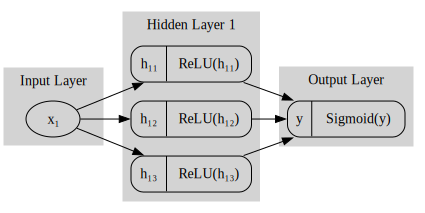

In [19]:
dot_graph = """
digraph G {
    rankdir=LR;

    // Input Layer
    subgraph cluster_input {
        label="Input Layer";
        style=filled;
        color=lightgrey;

        x1 [label="x₁"];
    }

    // Hidden Layer 1
    subgraph cluster_hidden1 {
        label="Hidden Layer 1";
        style=filled;
        color=lightgrey;

        h1_1 [label="{ h₁₁ | ReLU(h₁₁) }", shape=Mrecord];
        h1_2 [label="{ h₁₂ | ReLU(h₁₂) }", shape=Mrecord];
        h1_3 [label="{ h₁₃ | ReLU(h₁₃) }", shape=Mrecord];
    }


    // Output Layer
    subgraph cluster_output {
        label="Output Layer";
        style=filled;
        color=lightgrey;

        y [label="{ y | Sigmoid(y) }", shape=Mrecord];
    }

    // Connections
    x1 -> h1_1;
    x1 -> h1_2;
    x1 -> h1_3;



    h1_1 -> y;
    h1_2 -> y;
    h1_3 -> y;
}

"""

# Create a Source object from the DOT graph definition
source = Source(dot_graph)
# Display the graph
display(source)


### Sin on perceptron

In [20]:
batch_size = 100
num_weights = 5
torch.manual_seed(69)
x = torch.linspace(-2*np.pi, 2*np.pi, 1000, dtype=torch.float32).reshape(1000, 1)
y = torch.sin(x)


model = Perceptron(1, num_weights, 1).to(device)
y_pred, loss = nn_train(x, y, model, nn.MSELoss(), optim.Adam(model.parameters(), lr=1e-2), batch_size, epochs=int(2e2), device=device, verbose=False)

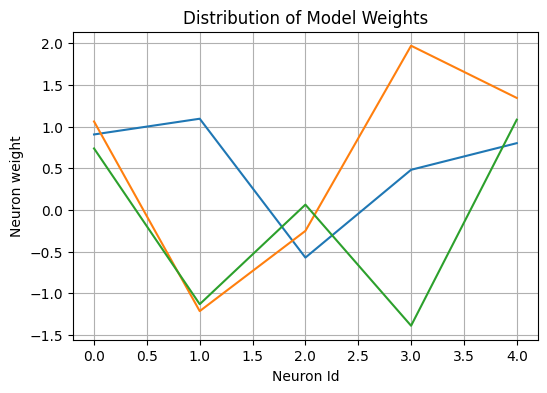

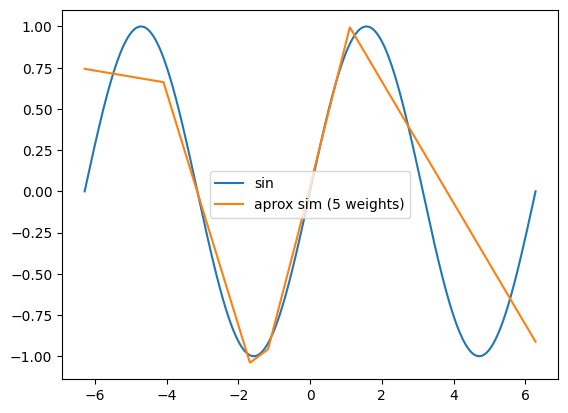

In [21]:
model.cpu().visualize_weights(verbose=False)
plt.plot(x, y, label="sin")
plt.plot(x, y_pred, label=f"aprox sim ({num_weights} weights)")
plt.legend()
plt.show()

### Heaviside on perceptron

In [22]:
batch_size = 10
num_weights_hs = 4
torch.manual_seed(69)
x_hs = torch.linspace(-2*np.pi, 2*np.pi, 10, dtype=torch.float32).reshape(10, 1)
y_hs = torch.heaviside(x_hs, torch.tensor(0.))

model_hs = Perceptron(1, num_weights_hs, 1).to(device)
y_hs_pred, loss = nn_train(x_hs, y_hs, model_hs, nn.MSELoss(), torch.optim.SGD(model_hs.parameters(), lr=0.05, momentum=0.9), batch_size, epochs=1000, device=device, verbose=False)

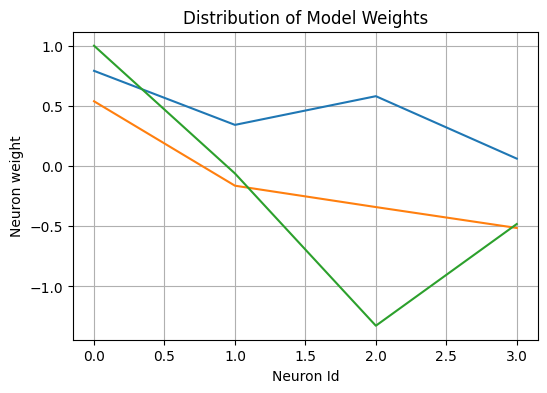

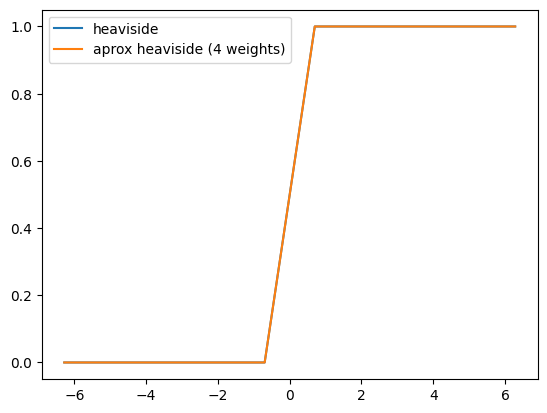

In [23]:
model_hs.cpu().visualize_weights(verbose=False)
plt.plot(x_hs, y_hs, label="heaviside")
plt.plot(x_hs, y_hs_pred, label=f"aprox heaviside ({num_weights_hs} weights)")
plt.legend()
plt.show()


As it is clear from above, with Linear function approximation that is used in Perceptron, it is opposite of polynomials.  
For polynomials - linear functions are effortless, while approximating non-linear functions is a bit of problem.  
For perceptrons -  non-linear functions such as Heaviside step are effortless, while linear functions (i.e. sine wave) are challenging. To improve approximation of smooth non-linear functions, one must increase number of weights.

In [24]:
batch_size = 100
num_weights_mw = 100
torch.manual_seed(69)
x_mw = torch.linspace(-2*np.pi, 2*np.pi, 1000, dtype=torch.float32).reshape(1000, 1)
y_mw = torch.sin(x_mw)


model_mw = Perceptron(1, num_weights_mw, 1).to(device)
y_mw_pred, loss_mw = nn_train(x_mw, y_mw, model_mw, nn.MSELoss(), optim.Adam(model_mw.parameters(), lr=1e-2), batch_size, epochs=int(8e2), device=device, verbose=False)

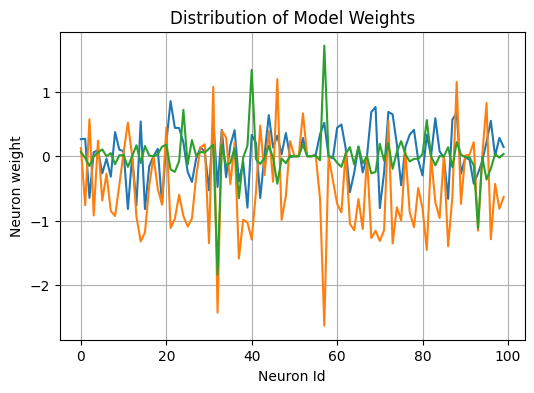

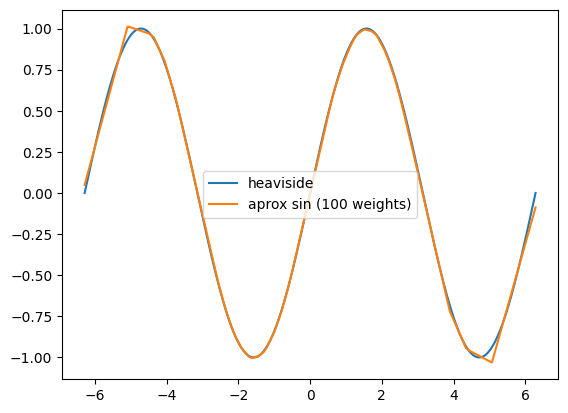

In [25]:
model_mw.cpu().visualize_weights(verbose=False)
plt.plot(x_mw, y_mw, label="heaviside")
plt.plot(x_mw, y_mw_pred, label=f"aprox sin ({num_weights_mw} weights)")
plt.legend()
plt.show()


Above representation is using **100** weights as opposed to **4** in heaviside.

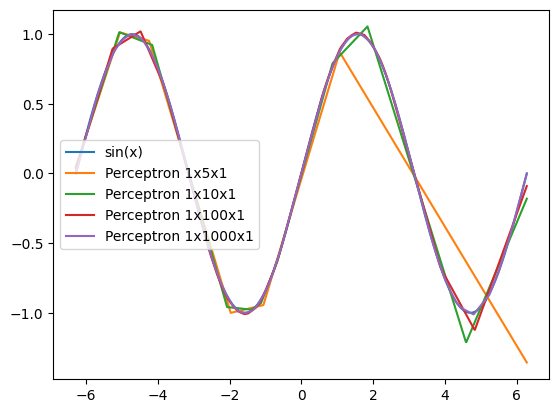

In [26]:
# See step function
batch_size = 100
torch.manual_seed(69)
x = torch.linspace(-2*np.pi, 2*np.pi, 1000, dtype=torch.float32).reshape(1000, 1)
y = torch.sin(x)

results = []
for num_params in [5, 10, 100, 1000]:
#for num_params in [5]:
    model = Perceptron(1, num_params, 1).to(device)
    results.append((num_params, nn_train(x,
                            y,
                            model,
                            nn.MSELoss(),
                            optim.Adam(model.parameters(), lr=1e-2),
                            batch_size,
                            epochs=int(8e2),
                            device=device,
                            verbose=False)[0]))

# Plot results
fig, ax = plt.subplots()
ax.plot(x, y, label="sin(x)")
for num_params, y_pred in results:
    ax.plot(x, y_pred, label=f"Perceptron 1x{num_params}x1")
    ax.set_title("")
plt.legend()
plt.show()

The values between two datapoints are extrapolated according to the slope of the linear function around the edges.  
In other words the precision of the output is only so good as the resolution of the training points and number of parameters.  